In [95]:
import datetime
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import hopsworks
import requests
import matplotlib.pyplot as plt
import joblib
import json

today = datetime.datetime.now()
print(f"Inference date: {today}")

Inference date: 2026-01-10 14:30:16.339448


## <span style='color:#ff5f27'> Imports

# <span style="font-width:bold; font-size: 3rem; color:#333;">Batch Inference Pipeline</span>

In [96]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/fingrid from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('fingrid',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH`
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env (if running locally)
# In GitHub Actions, environment variables are already set
if os.path.exists(f"{root_dir}/.env"):
    from mlfs import config
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")
else:
    # GitHub Actions environment - settings not needed
    settings = None

Local environment
Added the following directory to the PYTHONPATH: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book
HopsworksSettings initialized!


## <span style="color:#ff5f27;"> Connect to Hopsworks Feature Store </span>

In [97]:
project = hopsworks.login()
fs = project.get_feature_store()
mr = project.get_model_registry()

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("FINGRID_LOCATION_JSON").value
location = json.loads(location_str)

country = location['country']
city = location['city']

2026-01-10 14:30:16,399 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-10 14:30:16,411 INFO: Initializing external client
2026-01-10 14:30:16,413 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-10 14:30:18,122 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286359


## <span style="color:#ff5f27;">Download the model from Model Registry</span>

In [98]:
# Load all 4 models from fingrid/energy_model directory
models_dict = {}

# Define model paths (all in fingrid/energy_model)
model_dir = f"{root_dir}/fingrid/energy_model"

model_files = {
    'baseline': f"{model_dir}/energy_consumption_predictor.pkl",
    '1_day': f"{model_dir}/energy_consumption_predictor_1_day_lag.pkl",
    '2_day': f"{model_dir}/energy_consumption_predictor_2_day_lag.pkl",
    '3_day': f"{model_dir}/energy_consumption_predictor_3_day_lag.pkl",
}

# Load all models
for model_name, model_path in model_files.items():
    if os.path.exists(model_path):
        models_dict[model_name] = joblib.load(model_path)
        print(f"✓ {model_name} model loaded")
    else:
        print(f"✗ {model_name} model not found at: {model_path}")

print(f"\nTotal models loaded: {len(models_dict)}")
print(f"Models: {list(models_dict.keys())}")


✓ baseline model loaded
✓ 1_day model loaded
✓ 2_day model loaded
✓ 3_day model loaded

Total models loaded: 4
Models: ['baseline', '1_day', '2_day', '3_day']


## <span style="color:#ff5f27;">Get Weather Forecast Features</span>

In [99]:
# Get weather forecast data and historical energy data for lag features
weather_fg = fs.get_feature_group(
    name='weather_finland',
    version=1,
)
energy_fg = fs.get_feature_group(
    name='energy_consumption',
    version=1,
)

# Get 7 days of FUTURE forecast starting from today
batch_data = weather_fg.read()

# Ensure timezone-naive for filtering
if batch_data['date'].dt.tz is not None:
    batch_data['date'] = batch_data['date'].dt.tz_localize(None)

# Filter for next 7 days
start_date = pd.Timestamp(today.date())
end_date = start_date + pd.Timedelta(days=7)
batch_data = batch_data[
    (batch_data['date'] >= start_date) & (batch_data['date'] < end_date)
].copy()

print(f"Weather forecast data: {len(batch_data)} rows from {start_date.date()} to {end_date.date()}")
print(f"Date range: {batch_data['date'].min()} to {batch_data['date'].max()}")
print(f"Unique days: {batch_data['date'].dt.date.nunique()}")

# Get historical energy data to calculate lags (last 72+ hours)
energy_data = energy_fg.read()
energy_data['date'] = pd.to_datetime(energy_data['date'])
if energy_data['date'].dt.tz is not None:
    energy_data['date'] = energy_data['date'].dt.tz_localize(None)

# Get data from 72 hours before today
lookback_start = start_date - pd.Timedelta(hours=72)
energy_lookback = energy_data[
    (energy_data['date'] >= lookback_start) & (energy_data['date'] < start_date)
].copy().sort_values('date')

print(f"\nHistorical energy data for lag calculation: {len(energy_lookback)} rows")
print(f"Date range: {energy_lookback['date'].min()} to {energy_lookback['date'].max()}")

batch_data.head()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.28s) 
Weather forecast data: 56 rows from 2026-01-10 to 2026-01-17
Date range: 2026-01-10 00:00:00 to 2026-01-16 21:00:00
Unique days: 7
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.79s) 

Historical energy data for lag calculation: 384 rows
Date range: 2026-01-07 00:00:00 to 2026-01-09 06:21:00


,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country
5912,2026-01-10 00:00:00,-12.733333,0.0,100.0,27.733333,41.766667,16.000000,1015.166667,0.000000,Finland
5913,2026-01-10 06:00:00,-11.966667,0.0,100.0,31.466667,43.333333,17.333333,1011.366667,0.000000,Finland
5914,2026-01-10 03:00:00,-12.800000,0.0,100.0,27.600000,42.033333,15.666667,1013.800000,0.000000,Finland
5915,2026-01-10 18:00:00,-9.833333,0.3,100.0,31.933333,41.533333,27.333333,1008.266667,0.000000,Finland
5916,2026-01-10 15:00:00,-9.933333,0.3,100.0,33.366667,43.233333,25.333333,1008.366667,9.666667,Finland


In [100]:
# Diagnose weather forecast data
print(f"Total rows fetched: {len(batch_data)}")
print(f"Date range in weather data: {batch_data['date'].min()} to {batch_data['date'].max()}")
print(f"Unique dates: {batch_data['date'].dt.date.nunique()}")

print(f"\nRows per date:")
print(batch_data['date'].dt.date.value_counts().sort_index())

print(f"\nFirst few rows:")
print(batch_data[['date', 'temperature_2m', 'wind_speed_10m']].head(20))

Total rows fetched: 56
Date range in weather data: 2026-01-10 00:00:00 to 2026-01-16 21:00:00
Unique dates: 7

Rows per date:
date
2026-01-10    8
2026-01-11    8
2026-01-12    8
2026-01-13    8
2026-01-14    8
2026-01-15    8
2026-01-16    8
Name: count, dtype: int64

First few rows:
                    date  temperature_2m  wind_speed_10m
5912 2026-01-10 00:00:00      -12.733333       27.733333
5913 2026-01-10 06:00:00      -11.966667       31.466667
5914 2026-01-10 03:00:00      -12.800000       27.600000
5915 2026-01-10 18:00:00       -9.833333       31.933333
5916 2026-01-10 15:00:00       -9.933333       33.366667
5917 2026-01-10 21:00:00       -9.233333       30.233333
5918 2026-01-10 12:00:00      -10.466667       32.266667
5919 2026-01-10 09:00:00      -11.233333       33.966667
5920 2026-01-11 09:00:00       -8.266667       24.033333
5921 2026-01-11 18:00:00       -7.966667       21.233333
5922 2026-01-11 00:00:00       -8.700000       28.066667
5923 2026-01-11 06:00:00      

### <span style="color:#ff5f27;">Add Temporal Features</span>

In [101]:
# Add temporal features to forecast data
batch_data['year'] = batch_data['date'].dt.year
batch_data['month'] = batch_data['date'].dt.month
batch_data['day'] = batch_data['date'].dt.day
batch_data['hour'] = batch_data['date'].dt.hour
batch_data['day_of_week'] = batch_data['date'].dt.dayofweek
batch_data['is_weekend'] = (batch_data['day_of_week'] >= 5).astype(int)
batch_data['week_of_year'] = batch_data['date'].dt.isocalendar().week

print("Features created:")
print(batch_data.columns.tolist())
batch_data.head()

Features created:
['date', 'temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation', 'country', 'year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'week_of_year']


,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country,year,month,day,hour,day_of_week,is_weekend,week_of_year
5912,2026-01-10 00:00:00,-12.733333,0.0,100.0,27.733333,41.766667,16.000000,1015.166667,0.000000,Finland,2026,1,10,0,5,1,2
5913,2026-01-10 06:00:00,-11.966667,0.0,100.0,31.466667,43.333333,17.333333,1011.366667,0.000000,Finland,2026,1,10,6,5,1,2
5914,2026-01-10 03:00:00,-12.800000,0.0,100.0,27.600000,42.033333,15.666667,1013.800000,0.000000,Finland,2026,1,10,3,5,1,2
5915,2026-01-10 18:00:00,-9.833333,0.3,100.0,31.933333,41.533333,27.333333,1008.266667,0.000000,Finland,2026,1,10,18,5,1,2
5916,2026-01-10 15:00:00,-9.933333,0.3,100.0,33.366667,43.233333,25.333333,1008.366667,9.666667,Finland,2026,1,10,15,5,1,2


### <span style="color:#ff5f27;">Add Cyclic Features</span>

Convert temporal features to cyclic encoding (matching training pipeline)

In [102]:
# Create lag features from recent historical data
# We need to combine historical data with forecast data to have continuous consumption history

# Combine historical and forecast periods
combined_data = pd.concat([energy_lookback[['date', 'consumption_mw']], 
                          batch_data[['date']].copy()], ignore_index=True).sort_values('date')

# Create lag features (24h, 48h, 72h) on the combined data
lag_hours = [24, 48, 72]
for lag in lag_hours:
    combined_data[f'consumption_lag_{lag}h'] = combined_data.groupby(combined_data['date'].dt.date)['consumption_mw'].shift(lag).fillna(method='bfill').fillna(method='ffill')

# Extract lag features for the forecast period
batch_data = batch_data.merge(
    combined_data[['date', 'consumption_lag_24h', 'consumption_lag_48h', 'consumption_lag_72h']],
    on='date',
    how='left'
)

# Forward/backward fill any remaining NaNs
batch_data[['consumption_lag_24h', 'consumption_lag_48h', 'consumption_lag_72h']] = batch_data[['consumption_lag_24h', 'consumption_lag_48h', 'consumption_lag_72h']].fillna(method='bfill').fillna(method='ffill')

print("Lag features created for forecast period:")
print(batch_data[['date', 'consumption_lag_24h', 'consumption_lag_48h', 'consumption_lag_72h']].head(10))
batch_data.head()


2026-01-10 14:30:32,819 WARNING: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

2026-01-10 14:30:32,824 WARNING: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

2026-01-10 14:30:32,830 WARNING: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

2026-01-10 14:30:32,839 WARNING: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Lag features created for forecast period:
                 date  consumption_lag_24h  consumption_lag_48h  \
0 2026-01-10 00:00:00              14526.0              14153.0   
1 2026-01-10 06:00:00              14526.0              14153.0   
2 2026-01-10 03:00:00              14526.0              14153.0   
3 2026-01-10 18:00:

,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country,year,month,day,hour,day_of_week,is_weekend,week_of_year,consumption_lag_24h,consumption_lag_48h,consumption_lag_72h
0,2026-01-10 00:00:00,-12.733333,0.0,100.0,27.733333,41.766667,16.000000,1015.166667,0.000000,Finland,2026,1,10,0,5,1,2,14526.0,14153.0,13835.0
1,2026-01-10 06:00:00,-11.966667,0.0,100.0,31.466667,43.333333,17.333333,1011.366667,0.000000,Finland,2026,1,10,6,5,1,2,14526.0,14153.0,13835.0
2,2026-01-10 03:00:00,-12.800000,0.0,100.0,27.600000,42.033333,15.666667,1013.800000,0.000000,Finland,2026,1,10,3,5,1,2,14526.0,14153.0,13835.0
3,2026-01-10 18:00:00,-9.833333,0.3,100.0,31.933333,41.533333,27.333333,1008.266667,0.000000,Finland,2026,1,10,18,5,1,2,14526.0,14153.0,13835.0
4,2026-01-10 15:00:00,-9.933333,0.3,100.0,33.366667,43.233333,25.333333,1008.366667,9.666667,Finland,2026,1,10,15,5,1,2,14526.0,14153.0,13835.0


### <span style="color:#ff5f27;">Making the predictions</span>

In [103]:
# Make predictions with all 4 models
# Define feature requirements for each model
model_configs = {
    'baseline': {
        'features': ['year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'week_of_year',
                    'temperature_2m', 'precipitation', 'cloud_cover', 
                    'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 
                    'surface_pressure', 'shortwave_radiation'],
        'description': 'No lag features'
    },
    '1_day': {
        'features': ['year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'week_of_year',
                    'temperature_2m', 'precipitation', 'cloud_cover', 
                    'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 
                    'surface_pressure', 'shortwave_radiation',
                    'consumption_lag_24h'],
        'description': '1-day (24h) lag feature'
    },
    '2_day': {
        'features': ['year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'week_of_year',
                    'temperature_2m', 'precipitation', 'cloud_cover', 
                    'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 
                    'surface_pressure', 'shortwave_radiation',
                    'consumption_lag_48h'],
        'description': '2-day (48h) lag feature'
    },
    '3_day': {
        'features': ['year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'week_of_year',
                    'temperature_2m', 'precipitation', 'cloud_cover', 
                    'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 
                    'surface_pressure', 'shortwave_radiation',
                    'consumption_lag_72h'],
        'description': '3-day (72h) lag feature'
    }
}

# Make predictions with each model
predictions_all = {}

for model_name, config in model_configs.items():
    if model_name in models_dict:
        # Prepare features
        X_pred = batch_data[config['features']].copy()
        
        # Make predictions
        predictions_all[model_name] = models_dict[model_name].predict(X_pred)
        batch_data[f'predicted_{model_name}'] = predictions_all[model_name]
        
        print(f"✓ Predictions made with {model_name} model ({config['description']})")
        print(f"  Min: {predictions_all[model_name].min():.0f} MW, Max: {predictions_all[model_name].max():.0f} MW")
    else:
        print(f"✗ {model_name} model not available")

print("\nPredictions summary:")
print(batch_data[['date', 'predicted_baseline', 'predicted_1_day', 'predicted_2_day', 'predicted_3_day']].head(10))

✓ Predictions made with baseline model (No lag features)
  Min: 11527 MW, Max: 14339 MW
✓ Predictions made with 1_day model (1-day (24h) lag feature)
  Min: 13873 MW, Max: 14605 MW
✓ Predictions made with 2_day model (2-day (48h) lag feature)
  Min: 13842 MW, Max: 14621 MW
✓ Predictions made with 3_day model (3-day (72h) lag feature)
  Min: 13169 MW, Max: 14392 MW

Predictions summary:
                 date  predicted_baseline  predicted_1_day  predicted_2_day  \
0 2026-01-10 00:00:00        14066.364258     14063.050781     14071.002930   
1 2026-01-10 06:00:00        14143.999023     14175.280273     14146.465820   
2 2026-01-10 03:00:00        13985.553711     13958.245117     13950.734375   
3 2026-01-10 18:00:00        14023.593750     13878.908203     13900.275391   
4 2026-01-10 15:00:00        14226.444336     14044.122070     14086.642578   
5 2026-01-10 21:00:00        13279.526367     13872.970703     13964.476562   
6 2026-01-10 12:00:00        13909.511719     13928.312500

In [104]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 56 non-null     datetime64[us]
 1   temperature_2m       56 non-null     float64       
 2   precipitation        56 non-null     float64       
 3   cloud_cover          56 non-null     float64       
 4   wind_speed_10m       56 non-null     float64       
 5   wind_speed_100m      56 non-null     float64       
 6   wind_direction_10m   56 non-null     float64       
 7   surface_pressure     56 non-null     float64       
 8   shortwave_radiation  56 non-null     float64       
 9   country              56 non-null     object        
 10  year                 56 non-null     int32         
 11  month                56 non-null     int32         
 12  day                  56 non-null     int32         
 13  hour                 56 non-null     

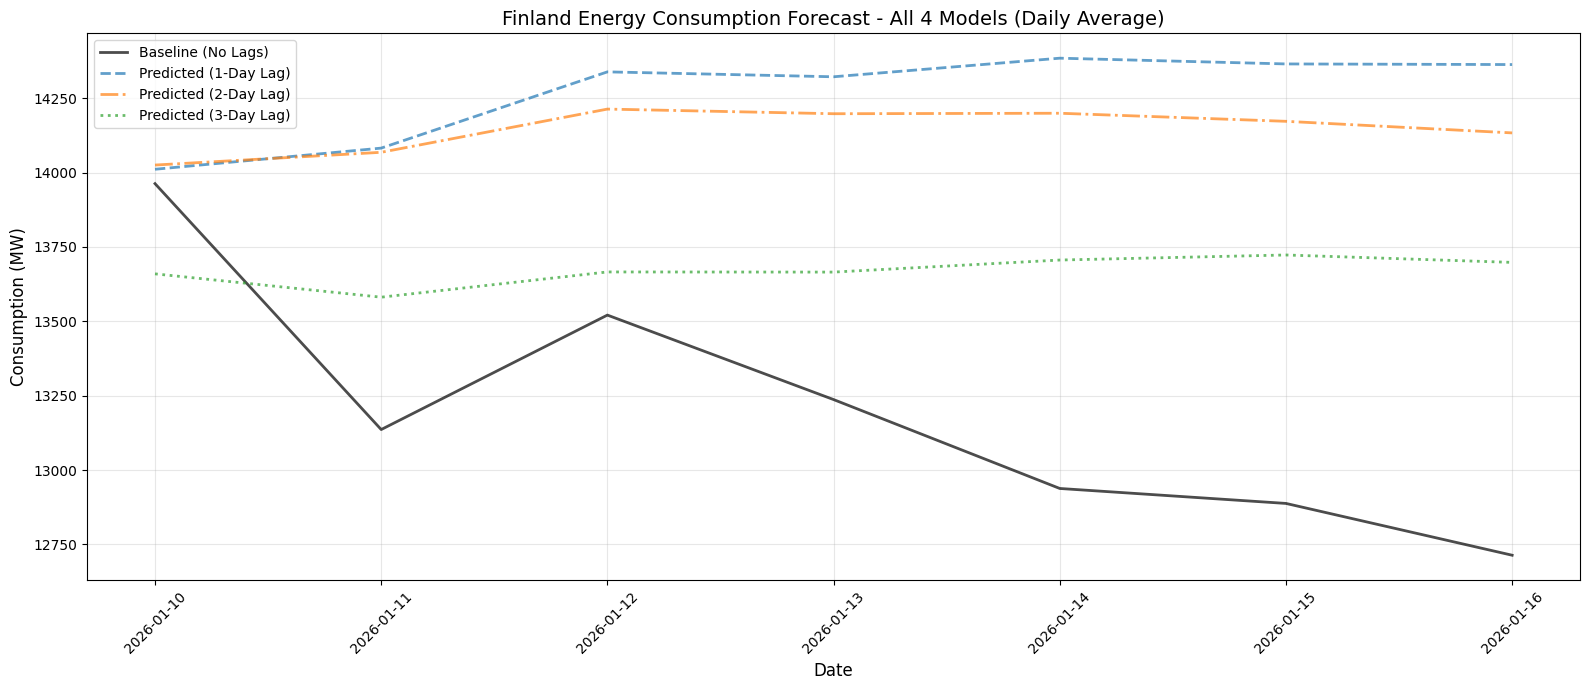

Forecast with all 4 models saved to: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/docs/fingrid/assets/img/energy_forecast_all_models.png
Forecasting 7 days


In [105]:
# Resample to daily averages for cleaner visualization
batch_data['date'] = pd.to_datetime(batch_data['date'])
# Select only numeric prediction columns for resampling
prediction_cols = ['predicted_baseline', 'predicted_1_day', 'predicted_2_day', 'predicted_3_day']
df_daily = batch_data[['date'] + prediction_cols].set_index('date').resample('D').mean().reset_index()

# Plot forecast with all 4 models
plt.figure(figsize=(16, 7))

# Define colors and linestyles for each model
colors = {
    'baseline': '#000000',      # Black
    '1_day': '#1f77b4',         # Blue
    '2_day': '#ff7f0e',         # Orange
    '3_day': '#2ca02c'          # Green
}

linestyles = {
    'baseline': '-',            # Solid
    '1_day': '--',             # Dashed
    '2_day': '-.',             # Dash-dot
    '3_day': ':'               # Dotted
}

labels = {
    'baseline': 'Baseline (No Lags)',
    '1_day': 'Predicted (1-Day Lag)',
    '2_day': 'Predicted (2-Day Lag)',
    '3_day': 'Predicted (3-Day Lag)'
}

# Plot each model's predictions
for model_name in ['baseline', '1_day', '2_day', '3_day']:
    if f'predicted_{model_name}' in df_daily.columns:
        plt.plot(df_daily['date'], df_daily[f'predicted_{model_name}'], 
                linewidth=2, alpha=0.7, label=labels[model_name],
                color=colors[model_name], linestyle=linestyles[model_name])

plt.xlabel('Date', fontsize=12)
plt.ylabel('Consumption (MW)', fontsize=12)
plt.title('Finland Energy Consumption Forecast - All 4 Models (Daily Average)', fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
pred_file_path = f"{root_dir}/docs/fingrid/assets/img/energy_forecast_all_models.png"
os.makedirs(os.path.dirname(pred_file_path), exist_ok=True)
plt.savefig(pred_file_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Forecast with all 4 models saved to: {pred_file_path}")
print(f"Forecasting {len(df_daily)} days")

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [106]:
# Add metadata for monitoring
batch_data['country'] = country
batch_data['days_before_forecast_day'] = (batch_data['date'] - pd.Timestamp(today.date())).dt.days
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country,...,is_weekend,week_of_year,consumption_lag_24h,consumption_lag_48h,consumption_lag_72h,predicted_baseline,predicted_1_day,predicted_2_day,predicted_3_day,days_before_forecast_day
0,2026-01-10 00:00:00,-12.733333,0.0,100.000000,27.733333,41.766667,16.000000,1015.166667,0.000000,Finland,...,1,2,14526.0,14153.0,13835.0,14066.364258,14063.050781,14071.002930,13963.458984,0
2,2026-01-10 03:00:00,-12.800000,0.0,100.000000,27.600000,42.033333,15.666667,1013.800000,0.000000,Finland,...,1,2,14526.0,14153.0,13835.0,13985.553711,13958.245117,13950.734375,13868.755859,0
1,2026-01-10 06:00:00,-11.966667,0.0,100.000000,31.466667,43.333333,17.333333,1011.366667,0.000000,Finland,...,1,2,14526.0,14153.0,13835.0,14143.999023,14175.280273,14146.465820,14078.104492,0
7,2026-01-10 09:00:00,-11.233333,0.0,100.000000,33.966667,45.500000,17.666667,1009.833333,13.666667,Finland,...,1,2,14526.0,14153.0,13835.0,14069.528320,14169.917969,14199.728516,13792.082031,0
6,2026-01-10 12:00:00,-10.466667,0.3,100.000000,32.266667,42.900000,18.000000,1008.666667,52.666667,Finland,...,1,2,14526.0,14153.0,13835.0,13909.511719,13928.312500,13885.069336,13430.032227,0
4,2026-01-10 15:00:00,-9.933333,0.3,100.000000,33.366667,43.233333,25.333333,1008.366667,9.666667,Finland,...,1,2,14526.0,14153.0,13835.0,14226.444336,14044.122070,14086.642578,13519.667969,0
3,2026-01-10 18:00:00,-9.833333,0.3,100.000000,31.933333,41.533333,27.333333,1008.266667,0.000000,Finland,...,1,2,14526.0,14153.0,13835.0,14023.593750,13878.908203,13900.275391,13456.737305,0
5,2026-01-10 21:00:00,-9.233333,0.4,100.000000,30.233333,39.766667,24.666667,1008.800000,0.000000,Finland,...,1,2,14526.0,14153.0,13835.0,13279.526367,13872.970703,13964.476562,13168.847656,0
10,2026-01-11 00:00:00,-8.700000,0.7,100.000000,28.066667,38.566667,24.666667,1008.866667,0.000000,Finland,...,1,2,14526.0,14153.0,13835.0,12706.905273,14028.403320,13959.998047,13801.834961,1
12,2026-01-11 03:00:00,-8.500000,0.5,100.000000,27.500000,36.833333,25.333333,1009.033333,0.000000,Finland,...,1,2,14526.0,14153.0,13835.0,12659.898438,13932.416016,13842.359375,13731.019531,1


In [ ]:
# Get or create monitoring feature group (version 3 with all 4 models)
monitor_fg = fs.get_or_create_feature_group(
    name='energy_predictions',
    description='Energy consumption prediction monitoring - all 4 models',
    version=3,
    primary_key=['country','date','days_before_forecast_day'],
    event_time="date"
)

In [108]:
# Keep predictions from all 4 models for monitoring
monitoring_data = batch_data[[
    'date', 'country', 'days_before_forecast_day', 
    'predicted_baseline', 'predicted_1_day', 'predicted_2_day', 'predicted_3_day'
]].copy()

monitor_fg.insert(monitoring_data, wait=True)
print(f"Inserted {len(monitoring_data)} predictions from all 4 models into monitoring feature group")
print(f"Columns saved: {[col for col in monitoring_data.columns if 'predicted' in col]}")


FeatureStoreException: Features are not compatible with Feature Group schema: 
 - predicted_consumption (type: 'float') is missing from input dataframe.
 - predicted_baseline (type: 'float') does not exist in feature group.
 - predicted_1_day (type: 'float') does not exist in feature group.
 - predicted_2_day (type: 'float') does not exist in feature group.
 - predicted_3_day (type: 'float') does not exist in feature group.
Note that feature (or column) names are case insensitive and spaces are automatically replaced with underscores.

### <span style="color:#ff5f27;">Create Hindcast - Compare Predictions vs Actual</span>

This shows how well the 1-day-ahead predictions matched actual consumption.

In [ ]:
# Get historical predictions made 1 day before
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
print(f"Historical predictions: {len(monitoring_df)} rows")
monitoring_df.head()

In [ ]:
# Get actual energy consumption data
energy_fg = fs.get_feature_group(name='energy_consumption', version=1)
energy_df = energy_fg.read()
print(f"Actual consumption data: {len(energy_df)} rows")
energy_df.head()

In [ ]:
# Resample actual consumption to daily averages
energy_df['date'] = pd.to_datetime(energy_df['date'])
energy_df['date_only'] = energy_df['date'].dt.date
energy_daily = energy_df.groupby('date_only')['consumption_mw'].mean().reset_index()
energy_daily.columns = ['date', 'actual_consumption']
energy_daily['date'] = pd.to_datetime(energy_daily['date'])

# Resample predictions to daily averages - only 1-day lag predictions
if len(monitoring_df) > 0:
    monitoring_df['date'] = pd.to_datetime(monitoring_df['date'])
    monitoring_df['date_only'] = monitoring_df['date'].dt.date
    
    # Aggregate 1-day model predictions to daily average
    preds_daily = monitoring_df.groupby('date_only').agg({
        'predicted_1_day': 'mean'
    }).reset_index()
    preds_daily.columns = ['date', 'predicted_1_day']
    preds_daily['date'] = pd.to_datetime(preds_daily['date'])
    
    # Merge predictions with actuals
    hindcast_df = pd.merge(preds_daily, energy_daily, on='date', how='inner')
    hindcast_df = hindcast_df.sort_values(by=['date'])
    
    # Filter to current week only (last 7 days)
    current_week_start = pd.Timestamp(today.date()) - pd.Timedelta(days=7)
    hindcast_df = hindcast_df[hindcast_df['date'] >= current_week_start]
    
    print(f"Hindcast data points (current week): {len(hindcast_df)}")
    print(f"Date range: {hindcast_df['date'].min().date()} to {hindcast_df['date'].max().date()}")
else:
    hindcast_df = pd.DataFrame()
    print("No historical predictions yet for hindcast")

hindcast_df.head()


### <span style="color:#ff5f27;">Plot Hindcast</span>

__This graph will be empty initially - this is normal.__

After a few days of predictions and observations, you will see data points comparing predictions vs actual consumption.

In [ ]:
plt.figure(figsize=(14, 6))

if len(hindcast_df) > 0:
    # Plot actual consumption
    plt.plot(hindcast_df['date'], hindcast_df['actual_consumption'], 
             linewidth=2.5, alpha=0.8, label='Actual Consumption', color='black', marker='o')
    
    # Plot 1-day ahead prediction
    plt.plot(hindcast_df['date'], hindcast_df['predicted_1_day'], 
             linewidth=2, alpha=0.7, label='1-Day Ahead Prediction', 
             color='#1f77b4', linestyle='--', marker='s')
else:
    plt.text(0.5, 0.5, 'Waiting for historical data...', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Consumption (MW)', fontsize=12)
plt.title('Finland Energy Consumption Hindcast - Current Week (1-Day Ahead)', fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
hindcast_file_path = f"{root_dir}/docs/fingrid/assets/img/energy_hindcast_all_models.png"
os.makedirs(os.path.dirname(hindcast_file_path), exist_ok=True)
plt.savefig(hindcast_file_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Hindcast saved to: {hindcast_file_path}")


### Upload the prediction and hindcast dashboards (png files) to Hopsworks

In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/fingrid") == False:
    dataset_api.mkdir("Resources/fingrid")
dataset_api.upload(pred_file_path, f"Resources/fingrid/{country}_{city}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/fingrid/{country}_{city}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/fingrid")